# Data preparation

This code transform the data into an appropriate format for stan model. First, it aggregates and standardises the values of environmental variables and data on buckwheat production for each county in China, and saves it into a csv file. It also merges the environmental data with the spatail polygons for counties, to show the values on the plots. Then it caluclates and saves the adjacency matrix for counties in Chinese to be used in iCAR model.

In [ ]:
install.packages("spdep","geosphere","data.table","geosphere","RColorBrewer","viridis")

In [ ]:
# Load libraries:
library(rgdal) # working with spatial data
library(raster) # working with later layers
library(data.table) # working with data frames
library(spdep) # calculating the adjacency matrix
require(geosphere) # calculating polygon area
library(here) # setting paths
library(viridis) # for colour schemes visualisation
library(RColorBrewer) # for colours on the plots
library(tmap) # for thematic mapping

In [2]:
### Set the paths for loading data

# Masked data on buckwheat production in China (masked to keep the data consistent:
path2prd<-here("data","buckwheat_production","masked")

# Environmental variables (cropped, because the border cells will have a consistent quality:
path2env <-here("data","environmental","present","masked")

# Path to past environmental data:
path2past <- here("data","environmental","past")

# Path to counties in China:
path2counties<-here("raw_data","CHN_adm")

# Path to full names of environmental variables:

path2env_table<-here("outputs","01_01_Predictor_variables.csv")

### Set the paths for outputs:
path2env_counties<-here("data","Env_by_county.csv")
path2envMaps<-here("outputs","ESM_12a.tiff")
path2envMapsAE<-here("outputs","ESM_12")
path2stats<- here("outputs","03_01_Env_Mean_and_SD.csv")
path2env_sd<- here("data","Sd_Env_by_county.csv")
path2prd_counties<-here("data","Prd_by_county.csv")
path2adjacency <- here("data","adjacency.csv")

In [37]:
### Load theme for plotting maps
source(here("R","theme_tmaps.R"))

In [ ]:
### Loading data:

# Get vector map of counties in China
china<-readOGR(dsn = path2counties, layer = "CHN_adm3")

# Get outer border of China
outer_border<-readOGR(dsn = path2counties, layer = "CHN_adm0")

In [39]:
# Get production dataset for China:
prd_layers<-list.files(path=path2prd,pattern='tif$',full.names=TRUE)
prd<-stack(prd_layers)

In [40]:
# Define variables that will be included in the analysis (are not autocorrelated)
var_names=c("BIO10","BIO17","BIO4","BIO9","npp")

# List all files with environmental variables
layers<-list.files(path=path2env,pattern='tif$',full.names=TRUE)

# Get only the environmental layers that are not autocorrelated
env_layers<-subset(layers,lapply(layers, grepl,pattern=paste(var_names,collapse="|"))==TRUE) # for the past
past_layers<-list.files(path=here(path2past,var_names,"masked"),pattern='tif$',full.names=TRUE) #for the present
env<-stack(c(env_layers,past_layers))

In [41]:
# Get the full names of environmental variables
env_table<-read.csv(path2env_table,row.names = 1)

## Aggregate the values of environmental predictors by county

In [29]:
# Extract weighted mean raster values of the cells for environmental variables for each county in China
r.mean <- extract(env,china,weights=TRUE,normalizeWeights=TRUE,fun="mean",na.rm=TRUE,df=TRUE)

In [32]:
# Check that no county has missing values:
sums<-rowSums(r.mean)
mc<-which(is.na(sums))

In [38]:
write.csv(r.mean[,-1],path2env_counties,row.names=TRUE)

## Standardise environmental variables

In [82]:
# Standardise environmental variables
# Get the mean and standard deviation of all the bioclimatic variables that will be used in a model:
stats<-lapply(var_names,function(x){ #Loop over all variables
    var_stack <- subset(env,colnames(r.mean[grep(x,colnames(r.mean))])) # Subset only columns with the specific variable
    var_stack[[-grep("15000",names(var_stack))]] # Get rid of the 15 000 layer for normalization
    vals<-as.vector(values(var_stack)) # Get all the values
    mean<-mean(vals, na.rm=TRUE) # Get the mean of the values
    sd<-sd(vals, na.rm=TRUE) # Get standard deviation of the values
    return(as.data.frame(cbind(mean,sd)))})

In [83]:
# Get the mean and standard deviations of the environmental variables into a dataframe
stats<-rbindlist(stats)
stats<-as.data.frame(stats)

# Name the rows according to the names of the environmental variables
rownames(stats) <- var_names

# Save the mean and standard deviation used for scaling and centering of the variables:
write.csv(stats, file=path2stats)

In [4]:
# Show the resulting table
stats

,mean,sd
,<dbl>,<dbl>
BIO10,18.882604,7.526035
BIO17,29.939598,55.843465
BIO4,1109.518224,338.131942
BIO9,-6.127758,10.807449
npp,429.293035,306.605444


In [84]:
# Standardize data
std_data<-lapply(var_names,function(x){
    data_sub<-r.mean[,grep(x,colnames(r.mean))]
    new_columns<-scale(data_sub,center=rep(stats[x,]$mean,ncol(data_sub)),scale=rep(stats[x,]$sd,ncol(data_sub)))
    new_columns<-as.data.frame(new_columns)
    colnames(new_columns)<-paste(colnames(new_columns),"sd",sep="_")
    return(new_columns)})

In [85]:
# Format standardised data as a data frame
std_data<-data.frame(std_data)

In [89]:
# Save standardised data as a data frame
write.csv(std_data,path2env_sd)

## Plot environmental variables for all time periods

In [42]:
# Load the data if needed:
r.mean<-read.csv(path2env_counties,row.names=1)
# Merge the data frame with the spatial polygons
china@data <- data.frame(china@data, r.mean)

In [43]:
# Set aesthetic for the plots of environmental data
# Set the colour schemes 
my_col<-c()
my_col[[1]]<-rev(brewer.pal(n = 9, name = "RdYlBu"))
my_col[[2]]<-rev(brewer.pal(n = 9, name = "RdYlBu"))
my_col[[3]]<-brewer.pal(n = 9, name = "Reds")
my_col[[4]]<-viridis(10)
my_col[[5]]<-brewer.pal(n = 9, name = "YlGnBu")
# Set plot order
plot_order<-c(4,1,3,5,2)
var_names<-names(env[[plot_order]]) # Reorder variable names
full_names<-env_table[var_names,] # Get full names of the variables
legends<-list("°C","°C","°C","g C m^−2 yr^−1","mm") # Set legend labels

In [44]:
# Define the plot predictions for present environmental conditions
env_maps<-tm_shape(china) +
    tm_graticules(lwd = 0.05,col="grey75",n.x=2,n.y=3,labels.size = 0.8)+
    tm_fill(col=var_names,n=5, style = "cont",palette=my_col,title=legends,legend.reverse = TRUE,showNA = F) +
    # Add the outer border to the plot
    tm_shape(outer_border)+
    tm_borders(col="grey75",lwd=1)+
    theme_tmaps+
    tm_layout(panel.labels=full_names,
              legend.position=c("left","bottom"),
              panel.label.height=2,
              panel.label.size = 1,
              legend.text.size = 0.6,
              legend.height=0.25)+
    tm_credits("Coordinate system: World Geodetic System 1984",position=c("left","bottom"))

Warning message in sp::proj4string(obj):
"CRS object has comment, which is lost in output"
Variable(s) "BIO9" contains positive and negative values, so midpoint is set to 0. Set midpoint = NA to show the full spectrum of the color palette.



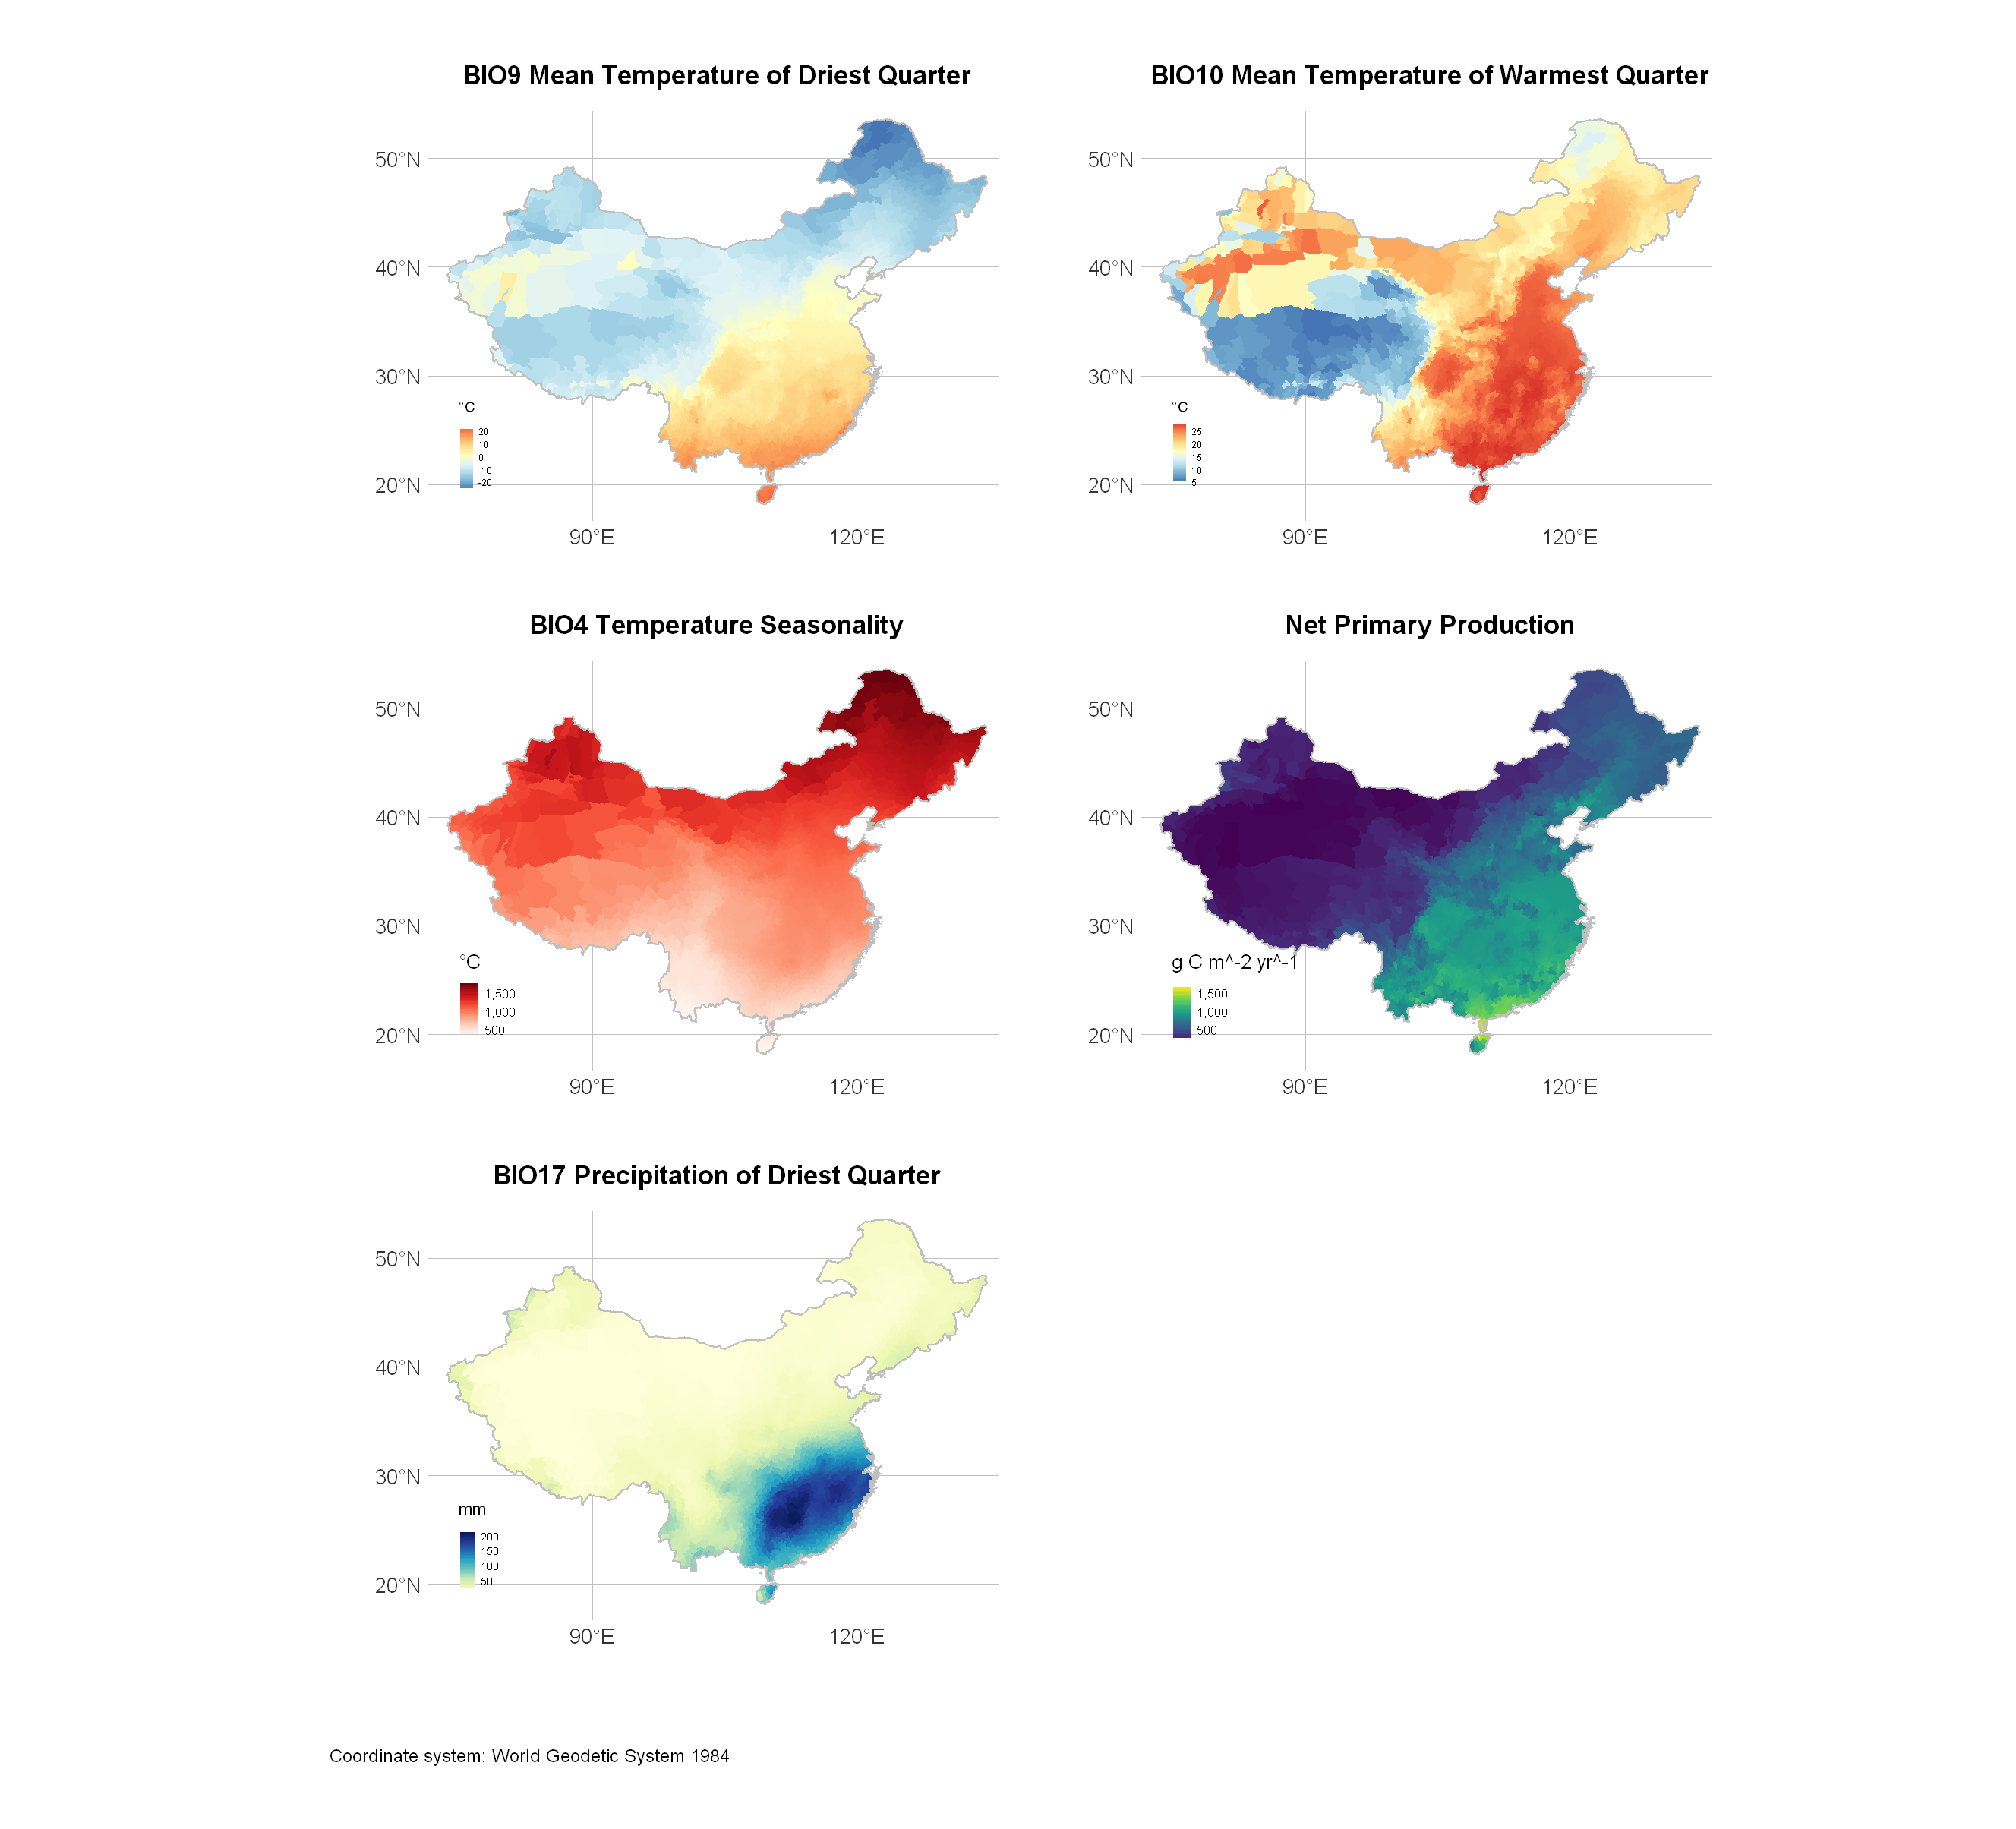

In [50]:
# Optionally show the image
env_maps

In [ ]:
# Save the plot
width=17.4
height=20.4
tmap_save(tm = env_maps,filename = path2envMaps,width = width,height = height,units = "cm",dpi = 600)


In [59]:
 env_map<-tm_shape(china) +
        tm_graticules(lwd = 0.05,col="grey75",n.x=2,n.y=3,labels.size = 0.8)+
        tm_fill(col=col_names, title=t,style = "cont",n=10,legend.reverse = FALSE,palette=my_col[[i]],showNA = F,legend.is.portrait = FALSE) +
       # Add the outer border to the plot
        tm_shape(outer_border)+
        tm_borders(col="grey75",lwd=1)+
        tm_facets(free.scales=FALSE,free.coords=FALSE,ncol=2,nrow=4)+
        theme_tmaps+
        tm_layout(panel.labels=period_labels,
              panel.label.height=1.5,
              panel.label.size = 1,
              legend.text.size = 0.6,
              legend.outside.size=0.1,
              legend.position=c("right","top"),
              legend.outside.position =c("bottom"),
              attr.position=c("left","bottom"),
              attr.outside.size=0.05,
                  inner.margins=c(0,0,0,0),
                  outer.margins=c(0.0000001,.0000001,0.0000001,0.0000001)
                 )+
tm_legend(width=.9,position=c("left", .5),frame=FALSE,bg.color="white")+
tm_credits("Coordinate system: World Geodetic System 1984",position=c("right", -0.06))

In [62]:
# Set the letters list for names
letters<-c("b","c","d","e","f")
# Set up the list to keep the maps in
env_maps<-c()
# Loop over all the environmental variables and plot them for all timeslices
for (i in c(1:length(letters))){
    # Get names of the columns with all time slices fot a given variable
    col_names<-colnames(china@data)[grep(var_names[i],colnames(china@data))][-1]
    # Get period labels
    period_labels<-paste(gsub(paste(var_names[i],"_",sep=""),"",col_names),"BP",sep=" ")
    # Get relevant legend for a variable
    t=legends[i]
    # Get relevant letter for plotting
    l=letters[i]
    env_map<-tm_shape(china) +
        tm_graticules(lwd = 0.05,col="grey75",n.x=2,n.y=3,labels.size = 0.8)+ # Add lat-long lines
        # Add layer
        tm_fill(col=col_names, title=t,style = "cont",n=10,legend.reverse = FALSE,palette=my_col[[i]],showNA = F,legend.is.portrait = FALSE) +
        #Add the outer border to the plot
        tm_shape(outer_border)+
        tm_borders(col="grey75",lwd=1)+
        # Define facets
        tm_facets(free.scales=FALSE,free.coords=FALSE,ncol=2,nrow=4)+
        theme_tmaps+
        tm_layout(panel.labels=period_labels,
              panel.label.height=1.5,
              panel.label.size = 1,
              legend.text.size = 0.6,
              legend.outside.size=0.1,
              legend.position=c("right","top"),
              legend.outside.position =c("bottom"),
              attr.position=c("left","bottom"),
              attr.outside.size=0.05,
                  inner.margins=c(0,0,0,0),
                  outer.margins=c(0.0000001,.0000001,0.0000001,0.0000001)
                 )+
tm_legend(width=.9,position=c("left", .5),frame=FALSE,bg.color="white")+ # Add legend
tm_credits("Coordinate system: World Geodetic System 1984",position=c("right", -0.06)) # Add info about map projection
env_maps[[i]]<-env_map # Save the map to the list for plotting in jupyter
    # Save the plot
    width=17.4
    height=23.4
    tmap_save(tm = env_maps,filename = paste(path2envMapsAE,l,".tiff",sep=""),width = width,height = height,units = "cm",dpi = 600)
}

Warning message in sp::proj4string(obj):
"CRS object has comment, which is lost in output"
Variable(s) "BIO9_1000", "BIO9_2000", "BIO9_3000", "BIO9_4000", "BIO9_5000", "BIO9_6000", "BIO9_7000", "BIO9_8000" contains positive and negative values, so midpoint is set to 0. Set midpoint = NA to show the full spectrum of the color palette.

Warning message in sp::proj4string(obj):
"CRS object has comment, which is lost in output"
Warning message in sp::proj4string(obj):
"CRS object has comment, which is lost in output"


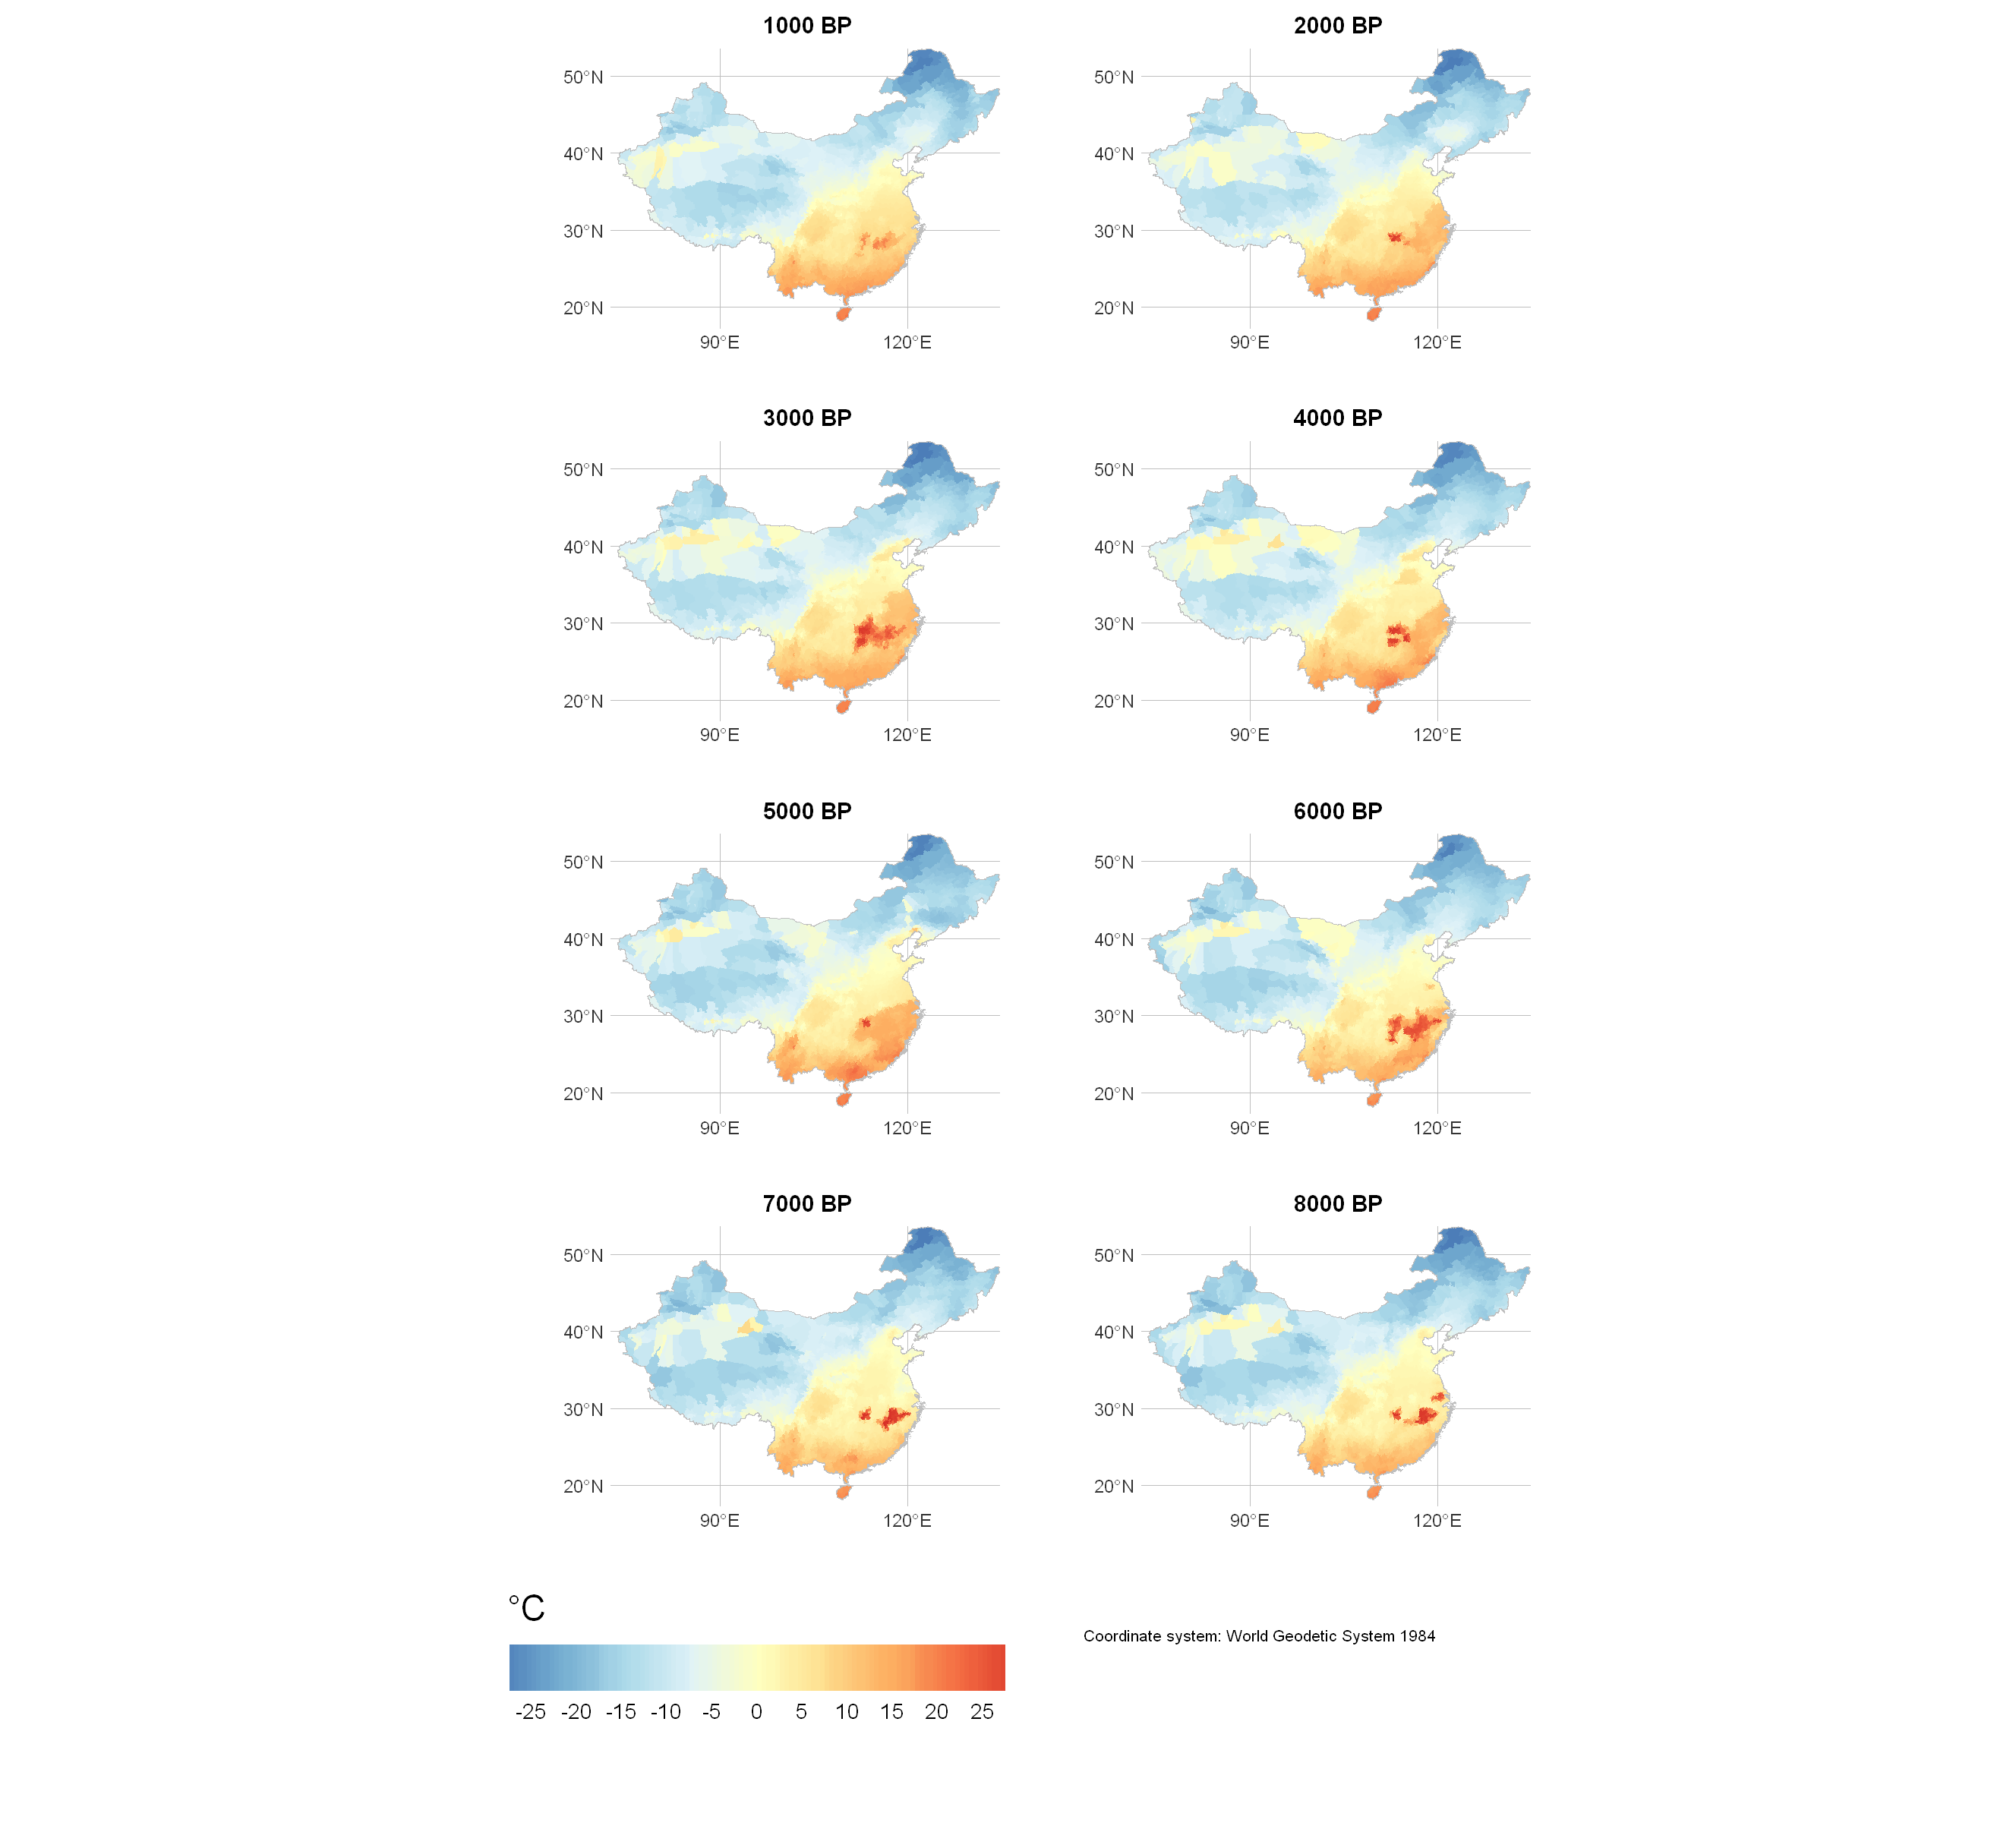

Warning message in sp::proj4string(obj):
"CRS object has comment, which is lost in output"


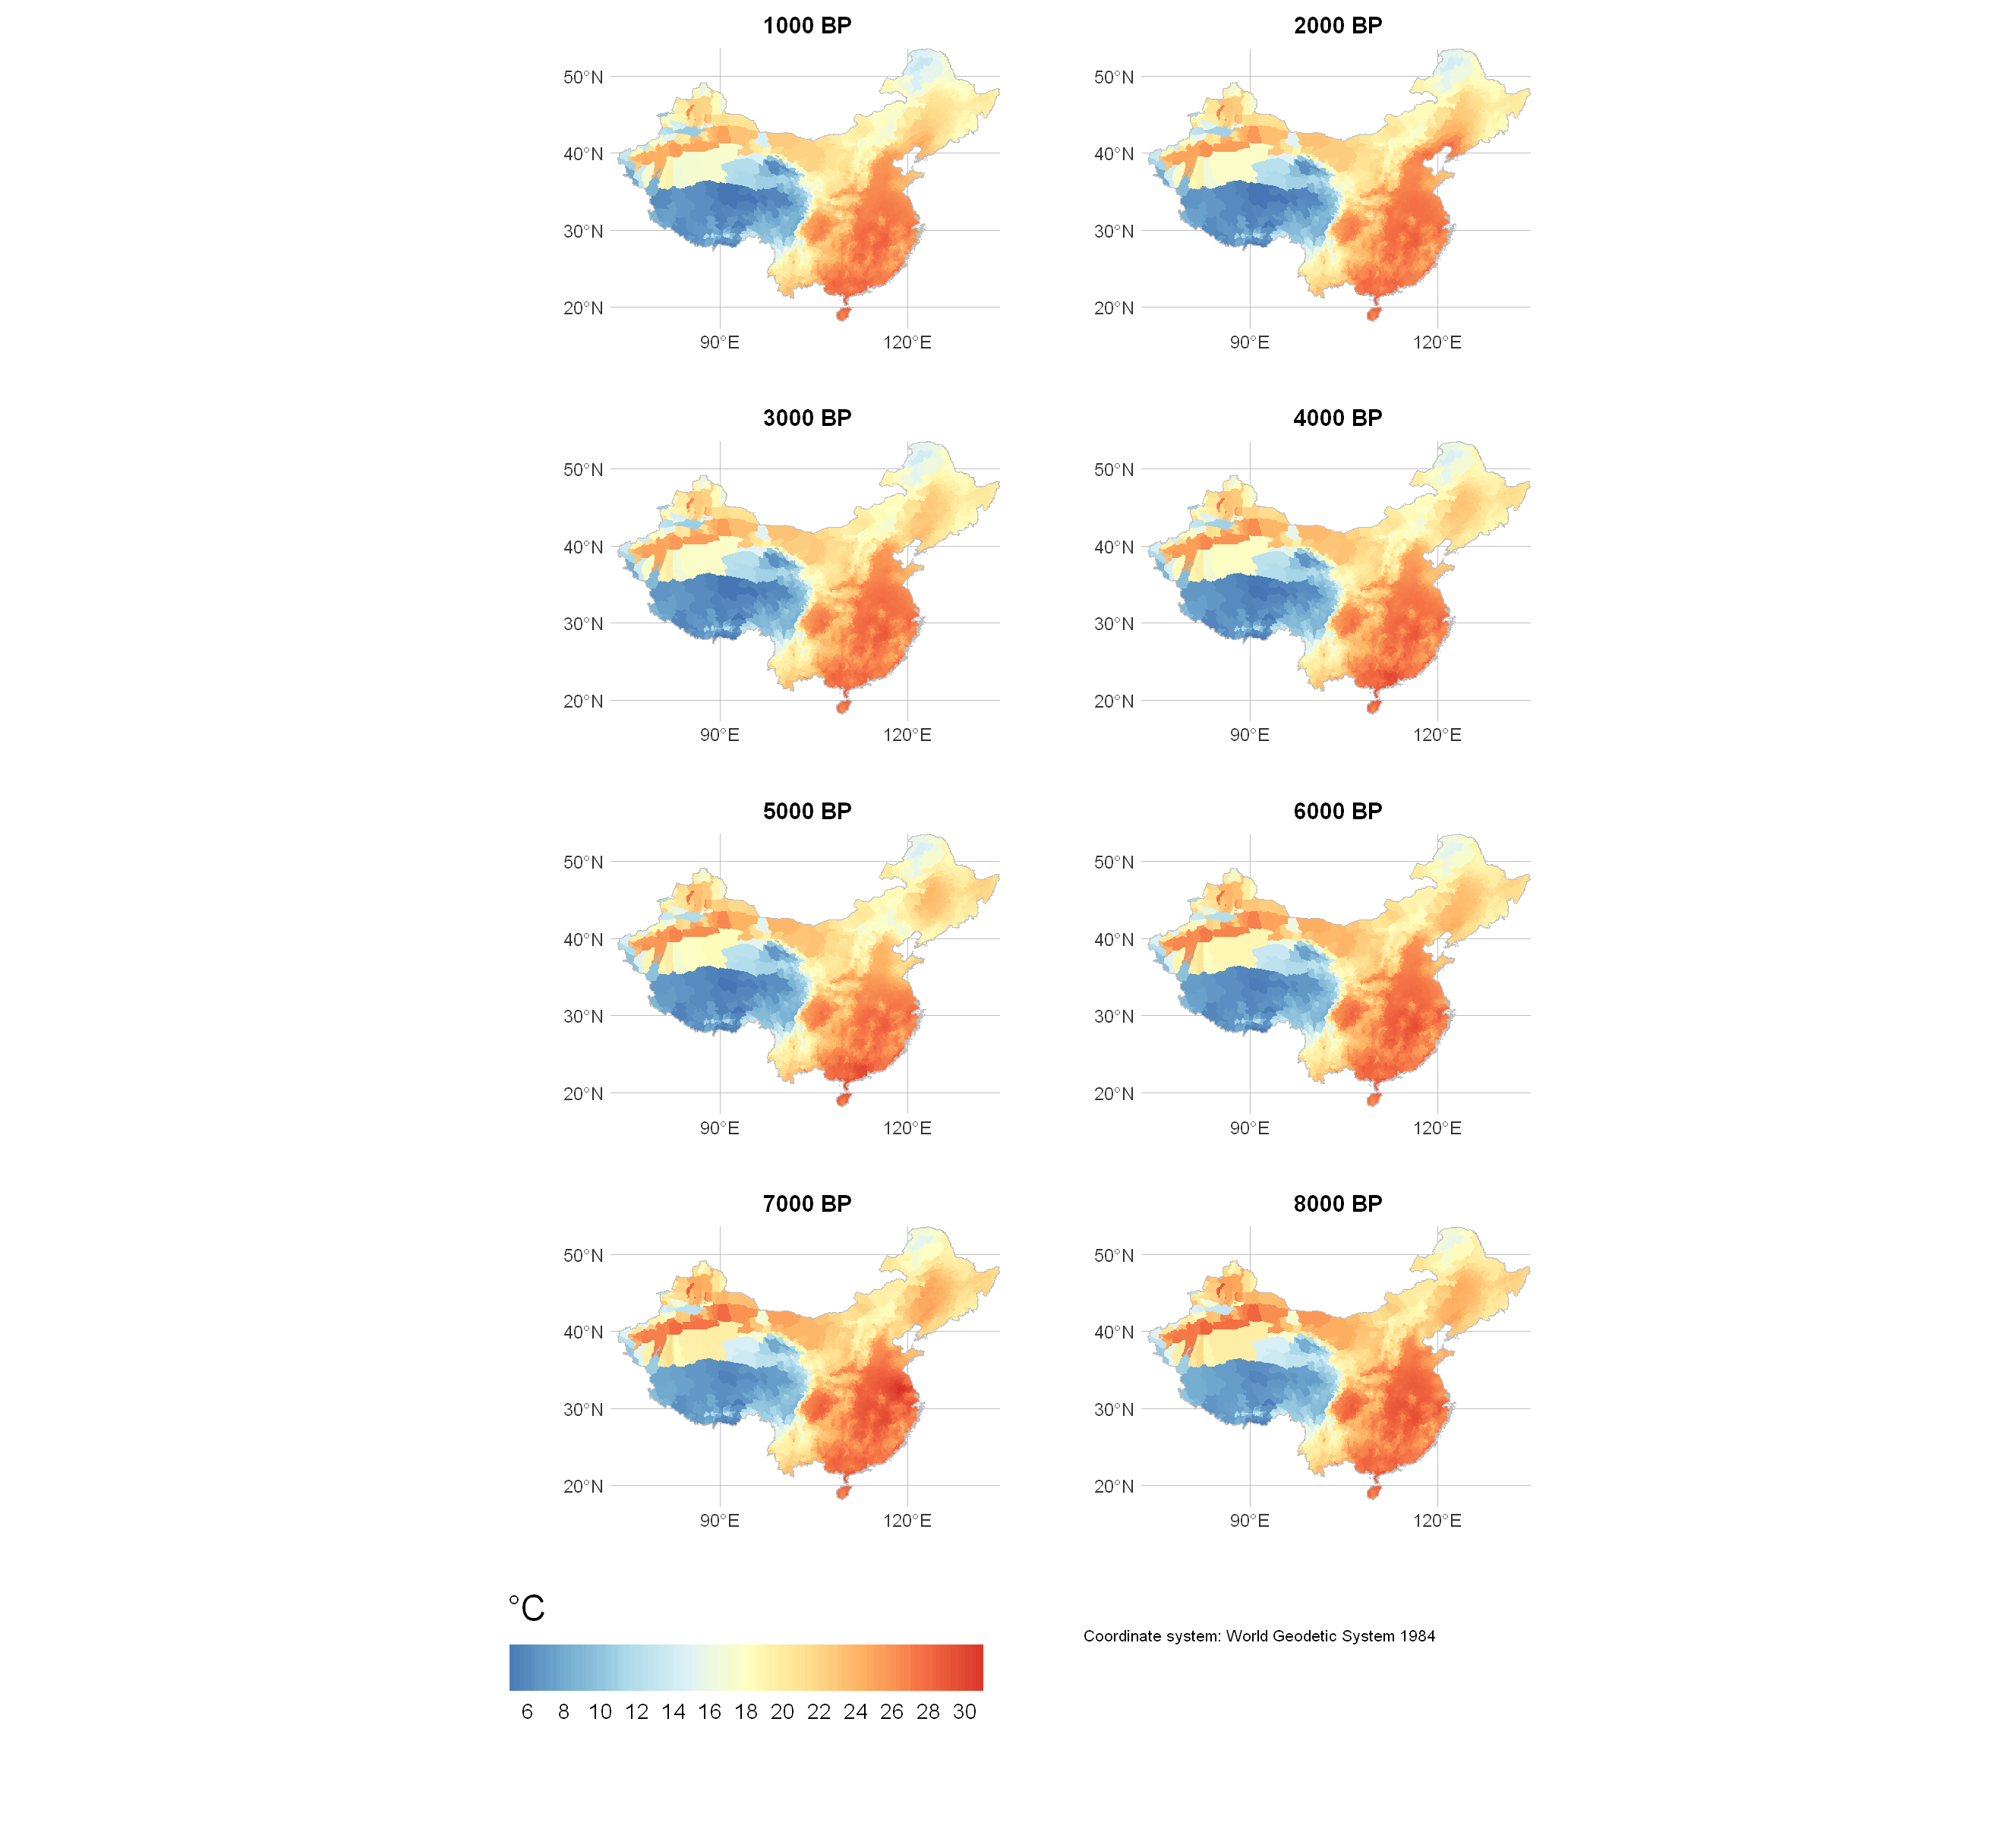

Warning message in sp::proj4string(obj):
"CRS object has comment, which is lost in output"


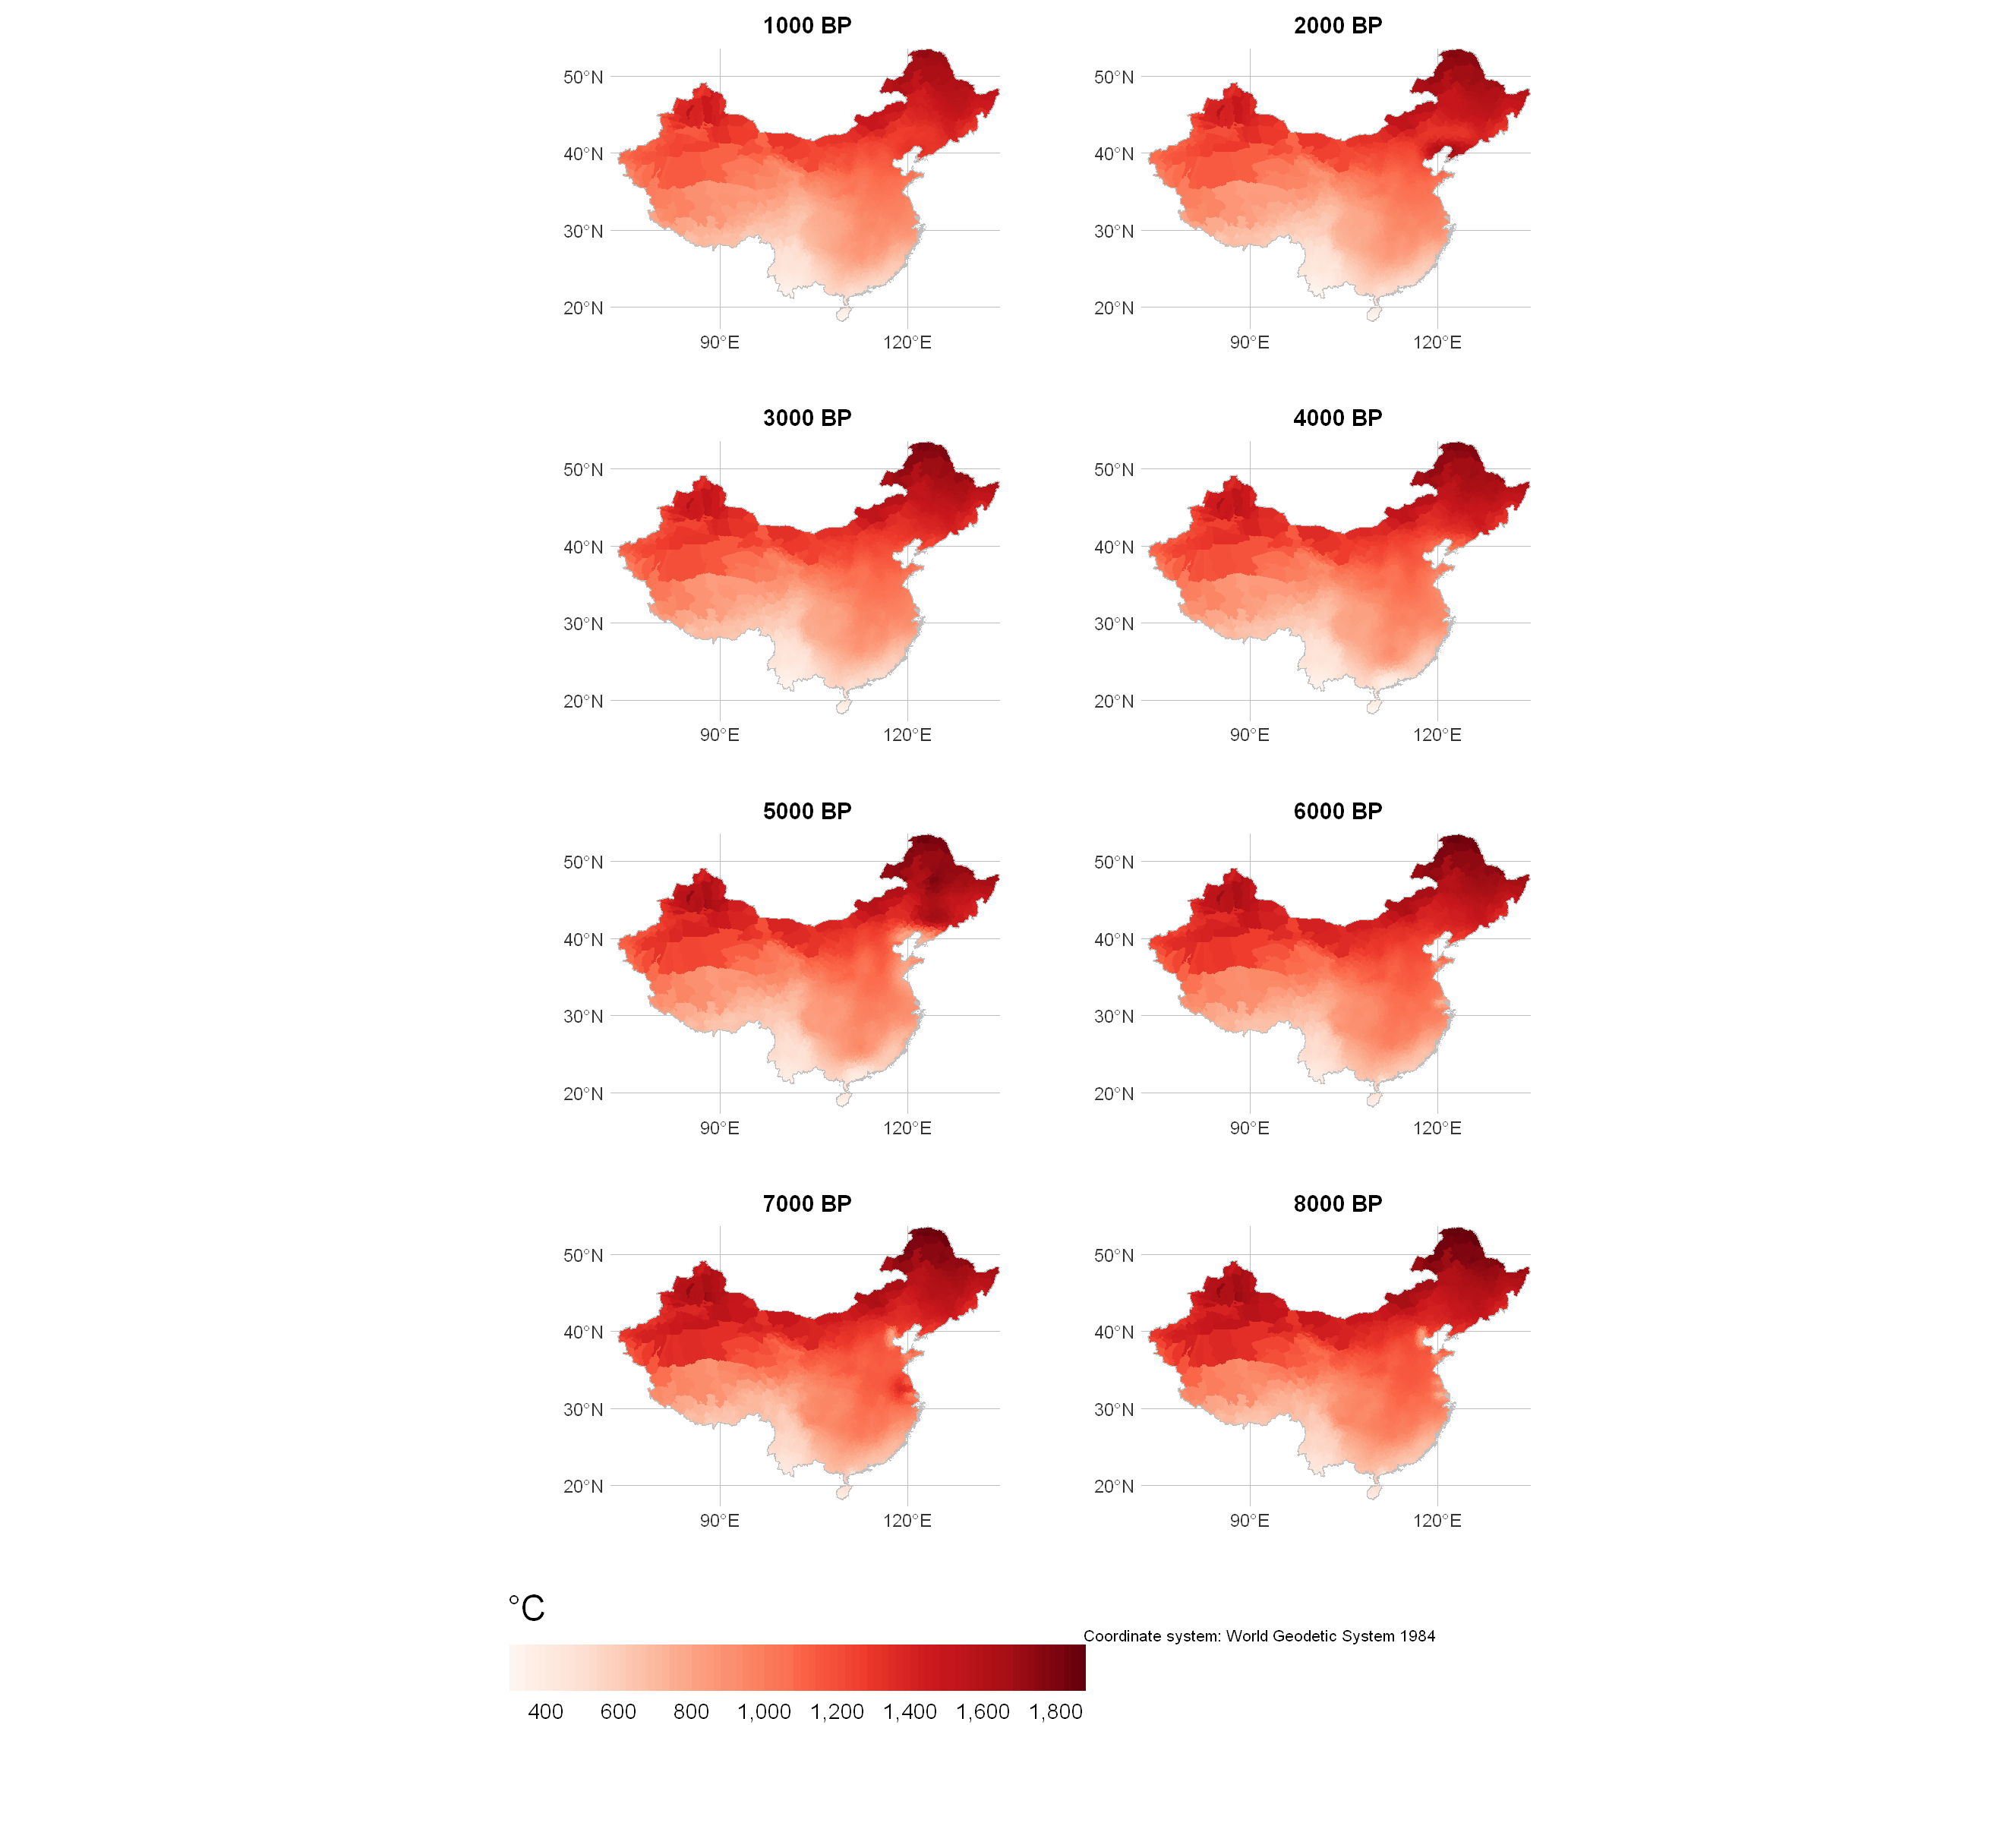

[[1]]

[[2]]

[[3]]

[[4]]

[[5]]


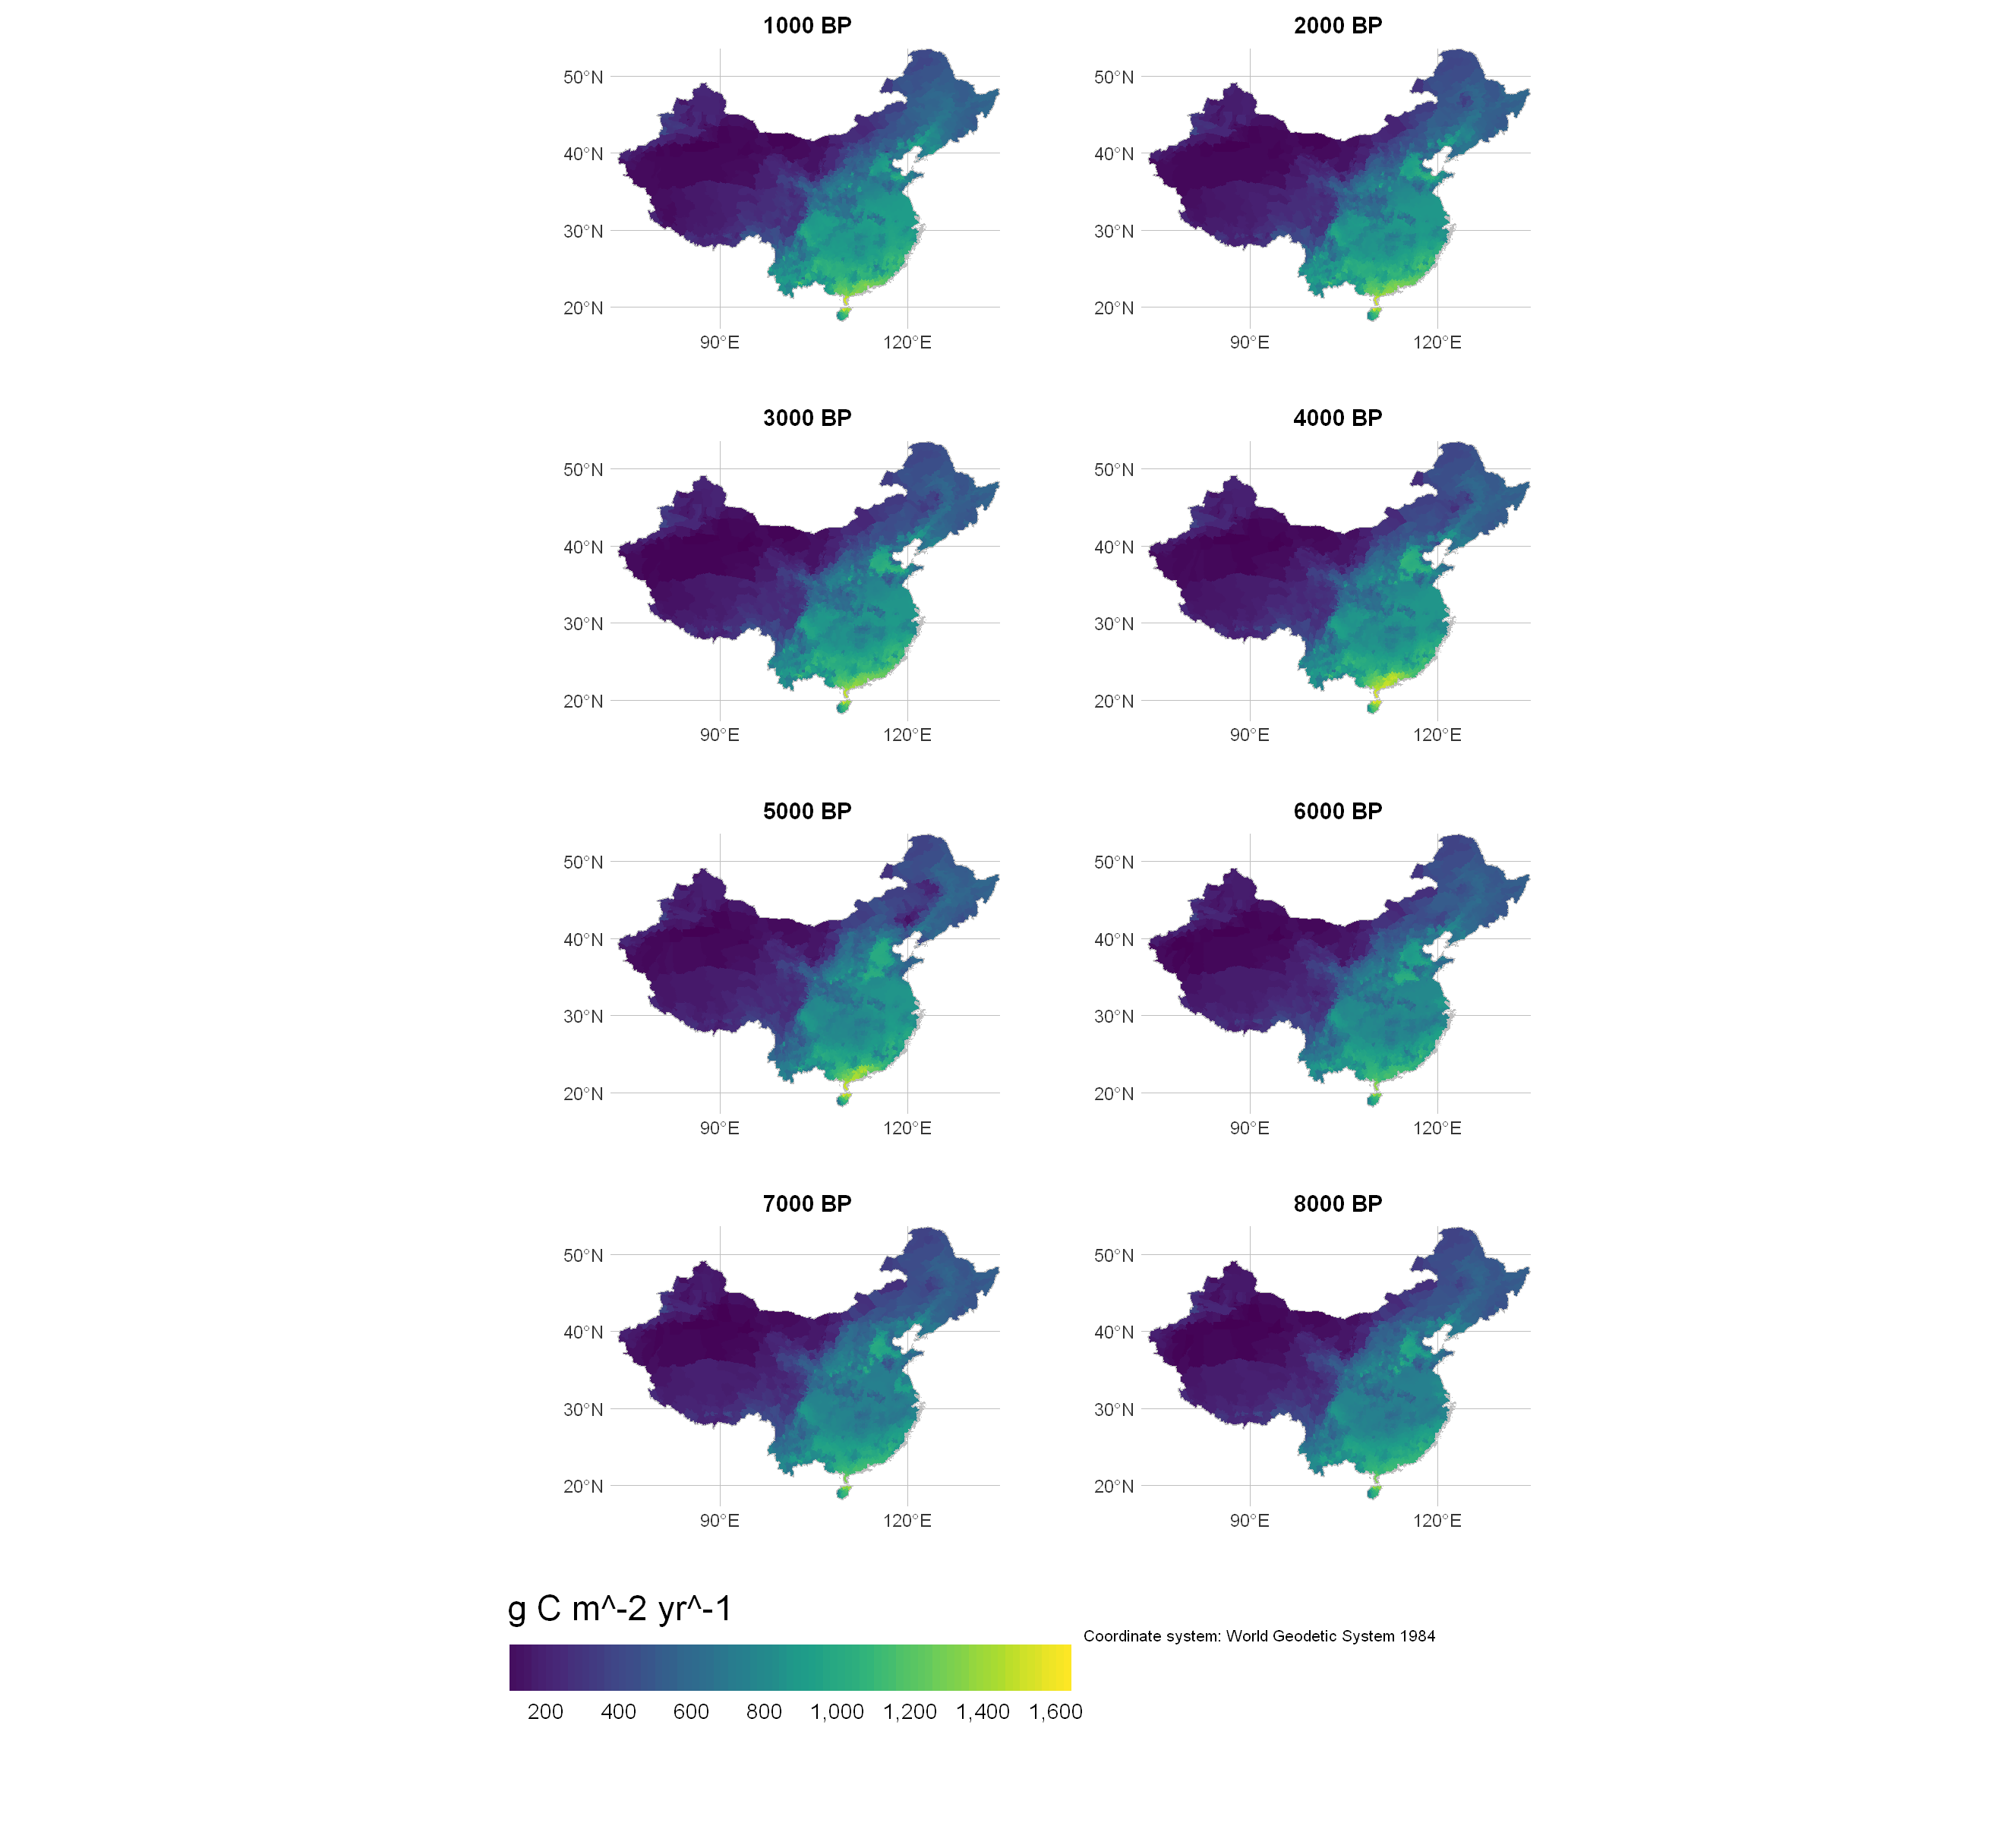

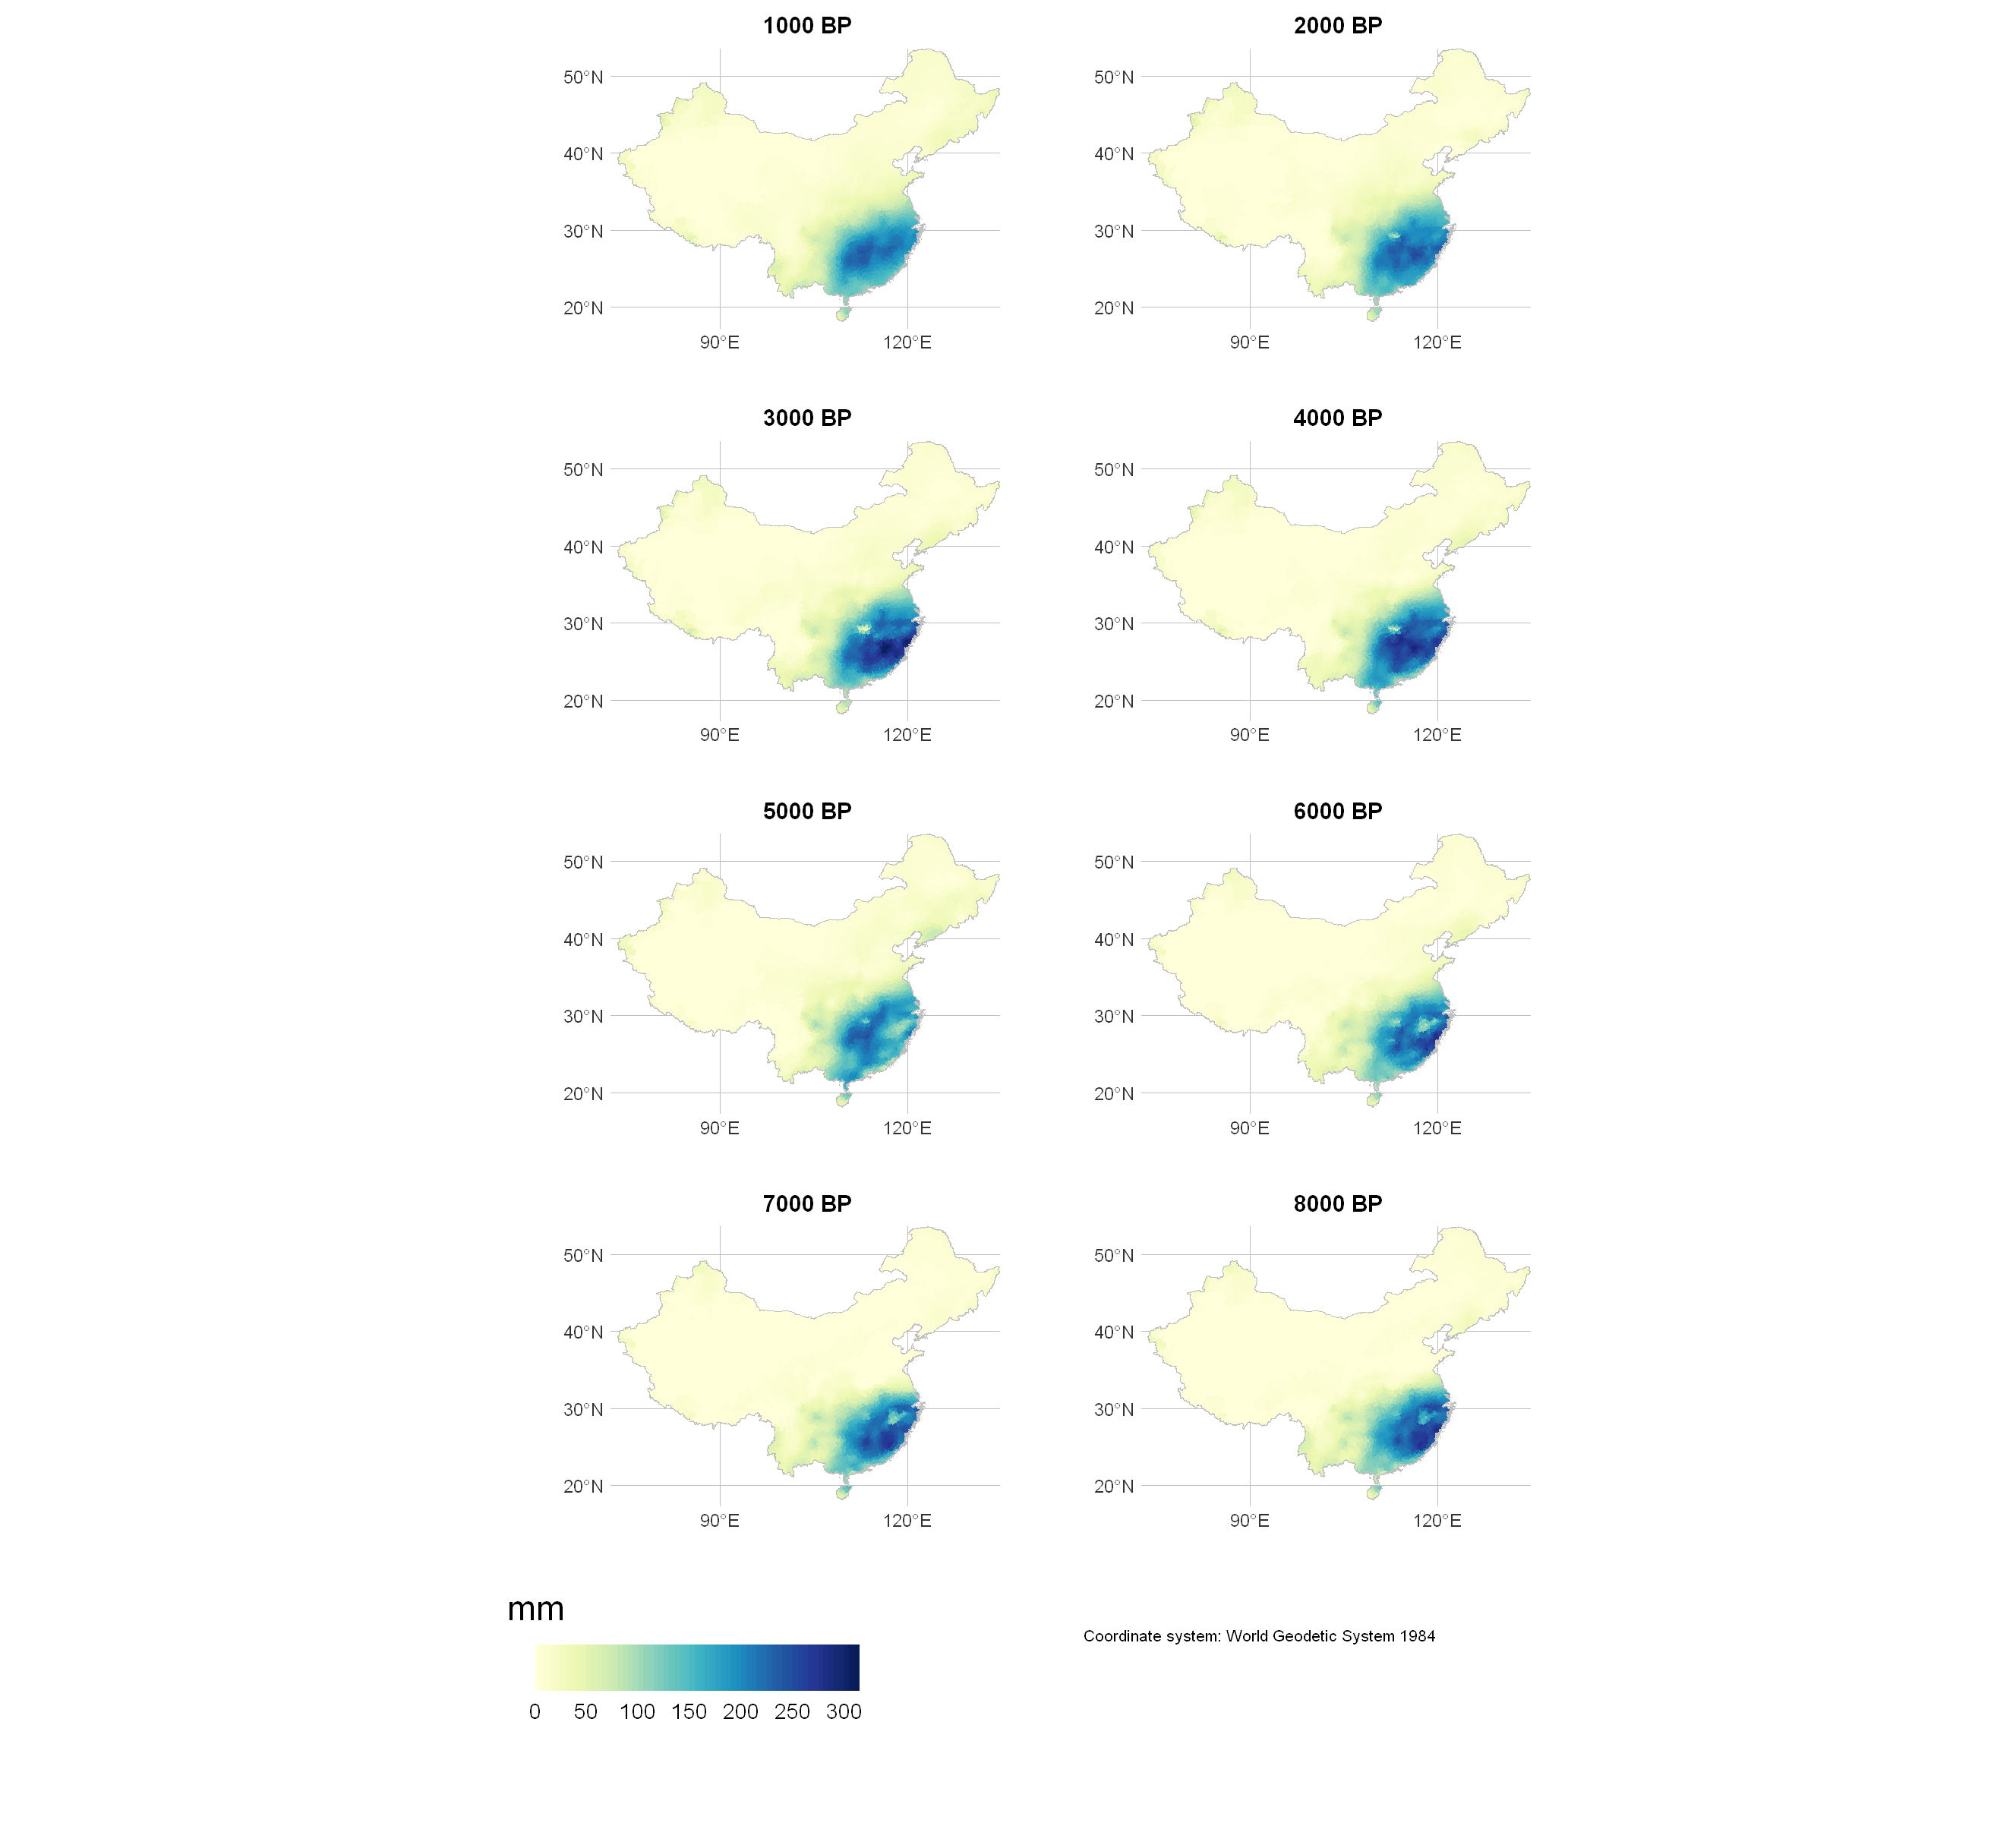

In [63]:
# Optionally: plot maps in jupyter
env_maps

## Extract and transform values for production for all counties

In [128]:
# Get data quality per county
r.mean.dq <- extract(prd[[c("buckwheat_DataQuality_HarvestedArea","buckwheat_DataQuality_Yield")]],china,
                     fun=function(x,na.rm){return(sort(x,decreasing=TRUE,na.last=na.rm)[1])},na.rm=TRUE,df=TRUE) # Get the most frequent data quality

In [ ]:
# Get weighted mean of yield per hectare and harvested area fraction per county
r.mean.pr <- extract(prd[[c("buckwheat_YieldPerHectare","buckwheat_HarvestedAreaFraction")]],china,
                     fun="mean",na.rm=TRUE,weights=TRUE,normalizeWeights=TRUE,df=TRUE)

In [ ]:
# Get the weighted sum of harvested area in hectares and buckwheat production in tonnes per county
r.sum.pr <- extract(prd[[c("buckwheat_HarvestedAreaHectares","buckwheat_Production")]],china,weights=TRUE,normalizeWeights=FALSE,na.rm=TRUE)
r.sum.pr$buckwheat_HarvestedAreaHectares<-r.sum.pr$weight*r.sum.pr$buckwheat_HarvestedAreaHectares
r.sum.pr$buckwheat_Production<-r.sum.pr$weight*r.sum.pr$buckwheat_Production
r.sum.pr<-data.table(r.sum.pr)
r.sum.pr <- r.sum.pr[,list(buckwheat_HarvestedAreaHectares = sum(buckwheat_HarvestedAreaHectares,na.rm=TRUE),
                           buckwheat_Production = sum(buckwheat_Production,na.rm=TRUE)), by = c("ID")]

In [160]:
# Get county areas:
area <- areaPolygon(china)

In [181]:
# Combine the extracted values for all counties:
r.values<-cbind(r.mean.dq[,-1],r.mean.pr[,-1],r.sum.pr[,-1],area)

In [191]:
# Check that there are no counties with missing values
sums<-rowSums(r.values)
mc<-which(is.na(sums))
mc

integer(0)

In [193]:
### Get the proportion of area which is cultivated, by dividing the cultivated area in hectares for the county, by the area of 
### the county. Area is given in square meters, and cultivated area in hectares, so multiply by 10 000.
r.values$AreaPr<-(as.numeric(as.character(r.values$buckwheat_HarvestedAreaHectares))/r.values$area)*10000

### Get the average produciont of buckwheat in tonnes, per hectar of a county
r.values$ProdHa<-(as.numeric(as.character(r.values$buckwheat_Production))/r.values$area)*10000

In [195]:
### Get the smallest possible values of AreaPr and Prod Ha:
sort(unique(r.values$AreaPr))[2]
sort(unique(r.values$ProdHa))[2]

[1] 2.284583e-10

[1] 1.112115e-10

In [197]:
### Get the logarithms for the proportion of the area of the county where buckwheat is cultivatad 
# and for average production in tonnes per hectare in a country.
# To transform into a logarithm add a small value (a magnitude smaller than the second smallest value in the column)
# to all of the numbers to avoind zeros:
r.values$logArea <- log(r.values$AreaPr+1e-11 )
r.values$logProd <- log(r.values$ProdHa+1e-11)

In [207]:
# Save the log area to a csv file
write.csv(r.values,path2prd_counties,row.names=TRUE)

## Calculate and save the adjacency matrix for iCAR

In [ ]:
### Calculate the adjacency matrix for the Spatial Polygons Data Frame:

# Gets the numbe of observations
N=nrow(china@data)

# Gets the adjacency
adj<-poly2nb(china)

# Define the nodes as vectors

node2 = vector(mode="numeric");
node1 = vector(mode="numeric");

# Get the values for each node
for (i in 1:N){
    a<-unlist(adj[i])
    a<-a[a>i]
    # Add to values of Node 1
    n1<-rep(i,length(a))
    node1 <-c(node1,n1)
    # Add values of Node 2
    node2<-c(node2,a)
}

# Bind into the adjacency matrix
mat<-cbind(node1, node2)

# Save the adjacency matrix
write.csv(mat, file=path2adjacency,row.names = FALSE)